In [2]:
import sys,os,time
import numpy as np
import pandas as pd
import copy
import threading

#--matplotlib
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rc('text',usetex=True)
import pylab  as py
from matplotlib.lines import Line2D

#--scipy 
from scipy.integrate import fixed_quad
from scipy.integrate import quad
from scipy.special import gamma
from scipy.optimize  import minimize,leastsq

#--mpmath
from mpmath import fp

from numba import jit

from special import beta as get_beta

import sys,os,time
import numpy as np
from numba import jit


<ipython-input-2-86fabd2540b2>:9: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [3]:
import alphaS
import mellin
import dglap
from special import beta
from tools import lprint

In [4]:
a=-0.5;b=3
N=mellin.N
pdf0=np.array([beta(n+a,b+1) for n in N])

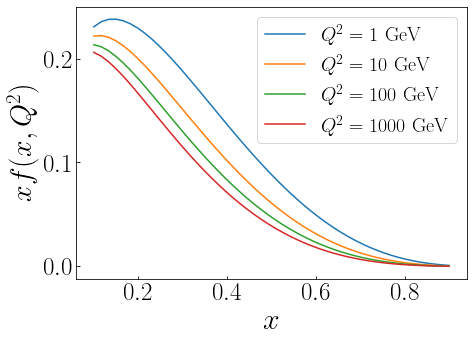

In [5]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(111)
x=np.linspace(0.1,0.9)
ax.plot(x,x*np.array([mellin.invert(_,pdf0) for _ in x]),label=r'$Q^2=1{\rm~GeV}$')
for Q2 in [10,100,1000]:
    pdf=dglap.evolve(pdf0,Q2)
    ax.plot(x,x*np.array([mellin.invert(_,pdf) for _ in x]),label=r'$Q^2=%d{\rm~GeV}$'%Q2)

ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xf(x,Q^2)$',size=30)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=25,direction='in')

In [6]:
@jit(nopython=True)
def get_sigma(x,Q2):
    pdf=dglap.evolve(pdf0,Q2)
    f=mellin.invert(x,pdf)
    return x*f

In [7]:
def gen_kinematics(rs,plot=True):
    Q2min=1
    W2min=4
    s=rs**2
    
    xmin=Q2min/rs**2
    xmax=0.5
    x=10**np.linspace(np.log10(xmin),np.log10(xmax),10)
    
    #x=np.array([0.1,0.2,0.3...])
    
    Q2max=xmax*s
    Q2=10**np.linspace(np.log10(Q2min),np.log10(Q2max),10)
    
    grid=[]
    M=0.938
    for x_ in x:
        for Q2_ in Q2:
            W2=M**2+Q2_*(1-x_)/x_
            if W2<W2min: continue
            Q2max=x_*s
            if Q2_>Q2max: continue
            grid.append([rs,x_,Q2_])
    grid=np.array(grid)

    if plot:
        nrows,ncols=1,1
        fig = py.figure(figsize=(ncols*7,nrows*5))
        rs,x,Q2=np.transpose(grid)

        ax=py.subplot(nrows,ncols,1)    
        ax.plot(x,Q2,'rs')
        #ax.legend(loc=2,fontsize=20)
        ax.semilogx()
        ax.semilogy()
        ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
        ax.set_xlabel(r'$x$',size=30)
        ax.set_ylabel(r'$Q^2$',size=30)


    return grid

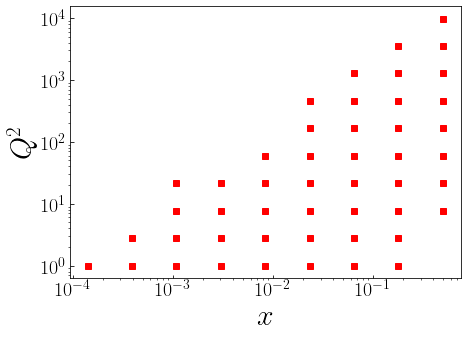

In [8]:
grid=gen_kinematics(140,plot=True);

In [9]:
table=[]
for kin in grid:
    rs,x,Q2=kin
    sigma=get_sigma(x,Q2)
    dsigma=0.1*sigma
    sigma+=np.random.randn()*dsigma
    table.append([rs,x,Q2,sigma,dsigma])
table=np.array(table)
pd.DataFrame(table,columns=['rs','x','Q2','sigma','err'])[:5]

,rs,x,Q2,sigma,err
0,140.0,0.000142,1.00000,0.012682,0.001190
1,140.0,0.000393,1.00000,0.018362,0.001981
2,140.0,0.000393,2.77632,0.021207,0.002183
3,140.0,0.001092,1.00000,0.027804,0.003293
4,140.0,0.001092,2.77632,0.035056,0.003609


Text(0, 0.5, '$\\sigma(x,Q^2)$')

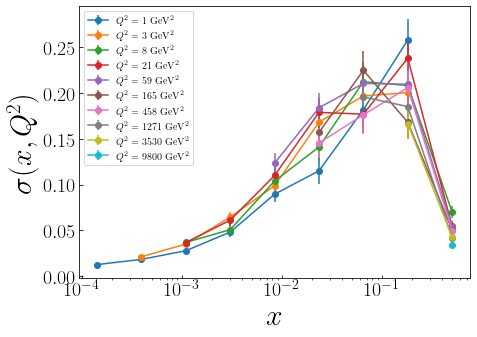

In [10]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))


ax=py.subplot(nrows,ncols,1)    
for var in np.unique(table[:,2]):
    cond=(table[:,2]==var)
    ax.errorbar(table[cond][:,1],table[cond][:,3],table[cond][:,4],fmt='-o',label=r'$Q^2=%0.0f~{\rm GeV^2}$'%var)
ax.legend(loc=2,fontsize=10)
ax.semilogx()
# ax.semilogy()
ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$\sigma(x,Q^2)$',size=30)

## fitting with solving DGLAP

In [11]:
N=mellin.N
@jit(nopython=True)
def get_pdf0N(par):
    a,b=par
    beta(N[0]+a,b+1)
    return np.array([beta(n+a,b+1) for n in N])

@jit(nopython=True)
def get_sigma(x,Q2,par):
    pdf=dglap.evolve(get_pdf0N(par),Q2)
    f=mellin.invert(x,pdf)
    return x*f



In [12]:
def get_parameter_samples(size):
    
    samples=[]
    cnt=0
    for _ in range(size):
        cnt+=1
        lprint('%d/%d'%(cnt,size))
        exp=table[:,3]+np.random.randn(table[:,3].size)*table[:,4]
        
        def get_residuals(par):
            thy=np.array([get_sigma(table[:,1][i],table[:,2][i],par) for i in range(table[:,3].size)])
            return (exp-thy)/table[:,4]

        par=leastsq(get_residuals,[1,1],full_output = 1)[0]
        samples.append(par)
    return samples

samples0=get_parameter_samples(100)

100/100

Text(0, 0.5, '$xf(x,Q^2_0)$')

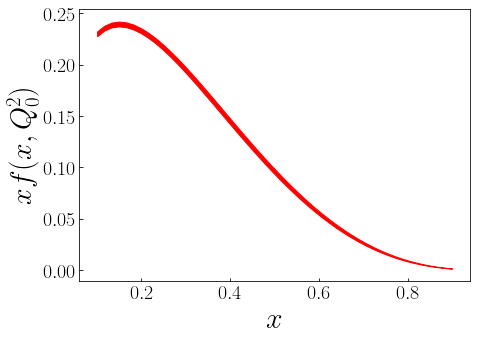

In [39]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(nrows,ncols,1)    

x=np.linspace(0.1,0.9)
pdf=[]
for par in samples0:
    pdf0=get_pdf0N(par)
    pdf.append([mellin.invert(_,pdf0) for _ in x])
mean0=np.mean(pdf,axis=0)
std0 =np.std(pdf,axis=0)
ax.fill_between(x,x*(mean0-std0),x*(mean0+std0),color='r')


ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xf(x,Q^2_0)$',size=30)

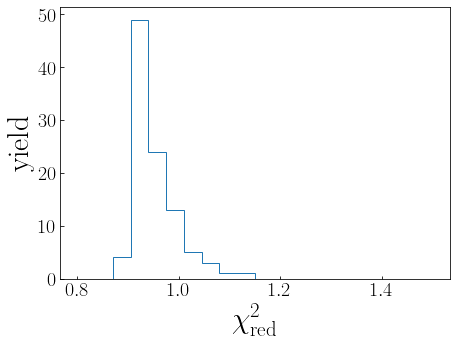

In [31]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(nrows,ncols,1)    

rchi2_0=[]
for par in samples0:
    thy=np.array([get_sigma(table[:,1][i],table[:,2][i],par)  for i in range(table[:,3].size)])
    res=(table[:,3]-thy)/table[:,4]
    chi2=np.sum(res**2)
    rchi2_0.append(chi2/res.size)
    
ax.hist(rchi2_0,range=(0.8,1.5),bins=20,histtype='step');
ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_xlabel(r'$\chi^2_{\rm red}$',size=30)
ax.set_ylabel(r'$\rm yield$',size=30);

## Duke Owens

In [17]:
import dukeowens as do

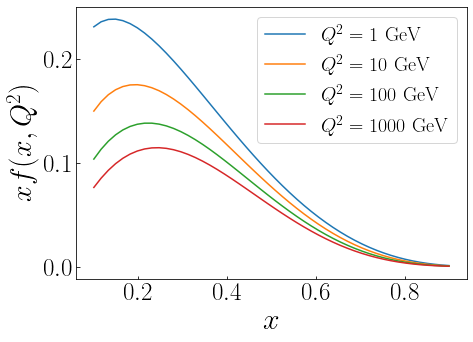

In [18]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(111)
x=np.linspace(0.1,0.9)
ax.plot(x,x*np.array([do.get_pdf(_,1,do.par) for _ in x]),label=r'$Q^2=1{\rm~GeV}$')
for Q2 in [10,100,1000]:
    ax.plot(x,x*np.array([do.get_pdf(_,Q2,do.par) for _ in x]),label=r'$Q^2=%d{\rm~GeV}$'%Q2)

ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xf(x,Q^2)$',size=30)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=25,direction='in')



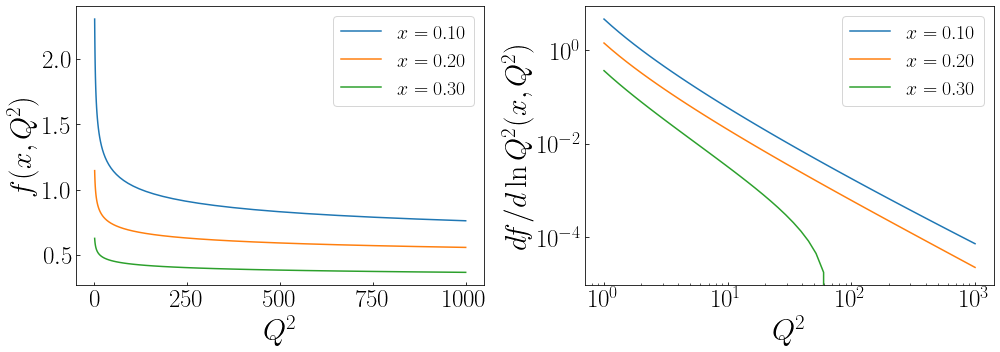

In [19]:
Q2=10**np.linspace(0,3)
x=0.1

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(nrows,ncols,1)
for x in [0.1,0.2,0.3]:
    ax.plot(Q2,np.array([do.get_pdf(x,_,do.par) for _ in Q2]),label=r'$x=%0.2f$'%x)

ax.set_xlabel(r'$Q^2$',size=30)
ax.set_ylabel(r'$f(x,Q^2)$',size=30)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=25,direction='in')


ax=py.subplot(nrows,ncols,2)
for x in [0.1,0.2,0.3]:
    ax.plot(Q2,np.array([do.get_dpdf_dQ(x,_,do.par) for _ in Q2]),label=r'$x=%0.2f$'%x)
ax.semilogx()
ax.semilogy()

ax.set_xlabel(r'$Q^2$',size=30)
ax.set_ylabel(r'$df/d\ln Q^2(x,Q^2)$',size=30)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=25,direction='in')

py.tight_layout()

In [20]:
@jit(nopython=True)
def get_sigma_duke_owens(x,Q2,par):
    f=do.get_pdf(x,Q2,par)
    return x*f


In [21]:
def get_parameter_samples(size):
    samples=[]
    cnt=0
    for _ in range(size):
        cnt+=1
        lprint('%d/%d'%(cnt,size))
        exp=table[:,3]+np.random.randn(table[:,3].size)*table[:,4]
        
        def get_residuals(par):
            thy=np.array([get_sigma_duke_owens(table[:,1][i],table[:,2][i],par) for i in range(table[:,3].size)])
            return (exp-thy)/table[:,4]

        par=leastsq(get_residuals,do.par,full_output = 1)[0]
        
        res=get_residuals(par)
        chi2=np.sum(res**2)
        rchi2=chi2/res.size
        #print(rchi2)
        samples.append(par)
        
    return samples

samples1=get_parameter_samples(100)

100/100

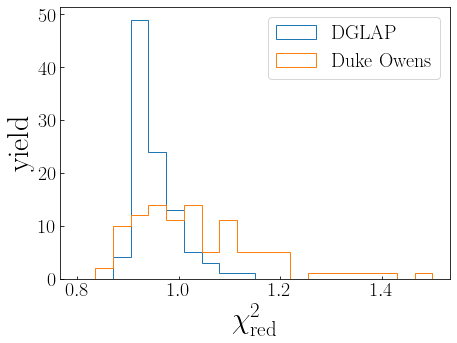

In [37]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(nrows,ncols,1)    

rchi2_1=[]
for par in samples1:
    thy=np.array([get_sigma_duke_owens(table[:,1][i],table[:,2][i],par) for i in range(table[:,3].size)])
    res=(table[:,3]-thy)/table[:,4]
    chi2=np.sum(res**2)
    rchi2_1.append(chi2/res.size)
    
ax.hist(rchi2_0,range=(0.8,1.5),bins=20,histtype='step',label=r'$\rm DGLAP$');
ax.hist(rchi2_1,range=(0.8,1.5),bins=20,histtype='step',label=r'$\rm Duke~Owens$');
ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_xlabel(r'$\chi^2_{\rm red}$',size=30)
ax.set_ylabel(r'$\rm yield$',size=30);
ax.legend(loc=1,fontsize=20)

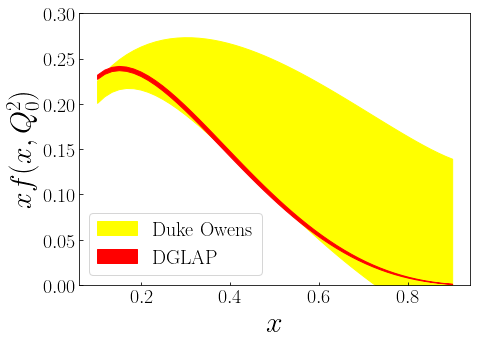

In [41]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(nrows,ncols,1)    

x=np.linspace(0.1,0.9)
Q2=1
pdf=[]
for par in samples1:
    pdf.append([do.get_pdf(_,Q2,par)for _ in x])
    #ax.plot(x,[do.get_pdf(_,Q2,par) for _ in x])
mean1=np.mean(pdf,axis=0)
std1 =np.std(pdf,axis=0)
ax.fill_between(x,x*(mean1-std1),x*(mean1+std1),color='yellow',label=r'$\rm Duke~Owens$')
ax.fill_between(x,x*(mean0-std0),x*(mean0+std0),color='r',label=r'$\rm DGLAP$')


ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xf(x,Q^2_0)$',size=30)
ax.set_ylim(0,0.3)
ax.legend(loc=3,fontsize=20)

In [42]:
from params import CF

In [43]:

@jit(nopython=True)
def get_conv(z,x,Q2,par):
    f =do.get_pdf(x/z,Q2,par)
    f0=do.get_pdf(x,Q2,par)
    conv=((1+z**2)*f/z - 2*f0)/(1-z) + 3/2*f0/(1-x)+np.log(1-x)*f0/(1-x) 
    return CF*conv

def get_grad(x,Q2,par):
    grad=quad(lambda z: get_conv(z,x,Q2,par),x,1)[0]
    grad*=alphaS.get_alphaS(Q2)/2/np.pi
    return grad/Q2

get_grad(0.5,10.,do.par)

-0.0015569380802371946

In [70]:
def get_parameter_samples(size):
    samples=[]
    cnt=0
    for _ in range(size):
        cnt+=1
        lprint('%d/%d'%(cnt,size))
        exp=table[:,3]+np.random.randn(table[:,3].size)*table[:,4]

        def get_residuals1(par):
            thy=np.array([get_sigma_duke_owens(table[:,1][i],table[:,2][i],par) for i in range(table[:,3].size)])
            res1=(exp-thy)/table[:,4]
            return res1

        par=leastsq(get_residuals1,do.par,full_output = 1)[0]
        
        def get_residuals2(par):
            thy=np.array([get_sigma_duke_owens(table[:,1][i],table[:,2][i],par) for i in range(table[:,3].size)])
            res1=(exp-thy)/table[:,4]
            
            test_grad=np.array([do.get_dpdf_dQ(table[:,1][i],table[:,2][i],par) for i in range(table[:,3].size)])
            true_grad=np.array([get_grad(table[:,1][i],table[:,2][i],par) for i in range(table[:,3].size)])
            res2=(test_grad-true_grad)/true_grad/20
            
            chi21=np.sum(res1**2)
            chi22=np.sum(res2**2)

            #print(chi21,chi21/res1.size,chi22)
            #return res1
            return np.append(res1,res2)

        par=leastsq(get_residuals2,par,full_output = 1)[0]
        
        #print()
        res=get_residuals1(par)
        chi2=np.sum(res**2)
        rchi2=chi2/res.size
        #print(rchi2)
        samples.append(par)
        
    return samples

#get_parameter_samples(1)
samples2=get_parameter_samples(100)


65/100

<ipython-input-43-e9a84049616c>:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  grad=quad(lambda z: get_conv(z,x,Q2,par),x,1)[0]


100/100

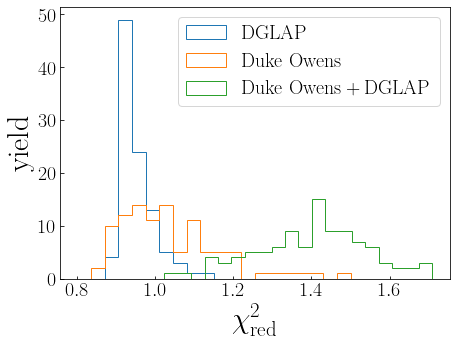

In [71]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(nrows,ncols,1)    

rchi2_2=[]
for par in samples2:
    thy=np.array([get_sigma_duke_owens(table[:,1][i],table[:,2][i],par) for i in range(table[:,3].size)])
    res=(table[:,3]-thy)/table[:,4]
    chi2=np.sum(res**2)
    rchi2_2.append(chi2/res.size)
    
ax.hist(rchi2_0,range=(0.8,1.5),bins=20,histtype='step',label=r'$\rm DGLAP$');
ax.hist(rchi2_1,range=(0.8,1.5),bins=20,histtype='step',label=r'$\rm Duke~Owens$');
ax.hist(rchi2_2,range=None,bins=20,histtype='step',label=r'$\rm Duke~Owens+DGLAP$');

ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_xlabel(r'$\chi^2_{\rm red}$',size=30)
ax.set_ylabel(r'$\rm yield$',size=30);
ax.legend(loc=1,fontsize=20)

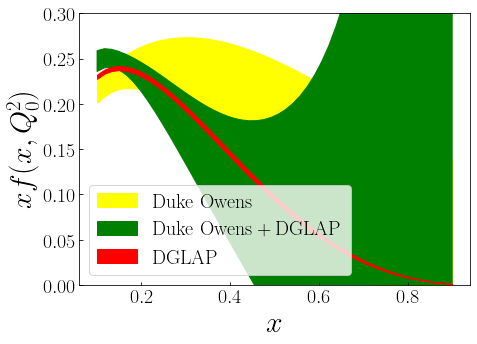

In [72]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(nrows,ncols,1)    

x=np.linspace(0.1,0.9)
Q2=1
pdf=[]
for par in samples2:
    pdf.append([do.get_pdf(_,Q2,par)for _ in x])
    #ax.plot(x,[do.get_pdf(_,Q2,par) for _ in x])
mean2=np.mean(pdf,axis=0)
std2 =np.std(pdf,axis=0)
ax.fill_between(x,x*(mean1-std1),x*(mean1+std1),color='yellow',label=r'$\rm Duke~Owens$')
ax.fill_between(x,x*(mean2-std2),x*(mean2+std2),color='g',label=r'$\rm Duke~Owens+DGLAP$')
ax.fill_between(x,x*(mean0-std0),x*(mean0+std0),color='r',label=r'$\rm DGLAP$')


ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$xf(x,Q^2_0)$',size=30)
ax.set_ylim(0,0.3)
ax.legend(loc=3,fontsize=20)